In [2]:
import pandas as pd
import os
import numpy as np
from PIL import Image
from natsort import natsorted
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/Final_project_Data/train_data_unlabeled.zip" -d "./train_data"
!unzip "/content/drive/MyDrive/Final_project_Data/test_data_unlabeled.zip" -d "./test_data"

In [4]:
def images_to_array_sorted(path):
    images = []
    image_filenames = natsorted(os.listdir(path))
    sum_channels = np.zeros(3)
    sum_squares_channels = np.zeros(3)
    pixel_count = 0

    for image in image_filenames:
        image_path = os.path.join(path,image)
        img = Image.open(image_path)
        img_array = np.array(img, dtype=np.float32)
        img_array /= 255.0
        rgb_image = img_array[:, :, :3]
        images.append(rgb_image)
    images = np.array(images)
    return images


In [5]:
train_path = './train_data/train_data_unlabeled'
train_images = images_to_array_sorted(train_path)

test_path = './test_data/test_data_unlabeled'
test_images = images_to_array_sorted(test_path)

y_train_csv = '/content/drive/MyDrive/Final_project_Data/y_train.csv'
y_train_df = pd.read_csv(y_train_csv)
labels = y_train_df['target'].values


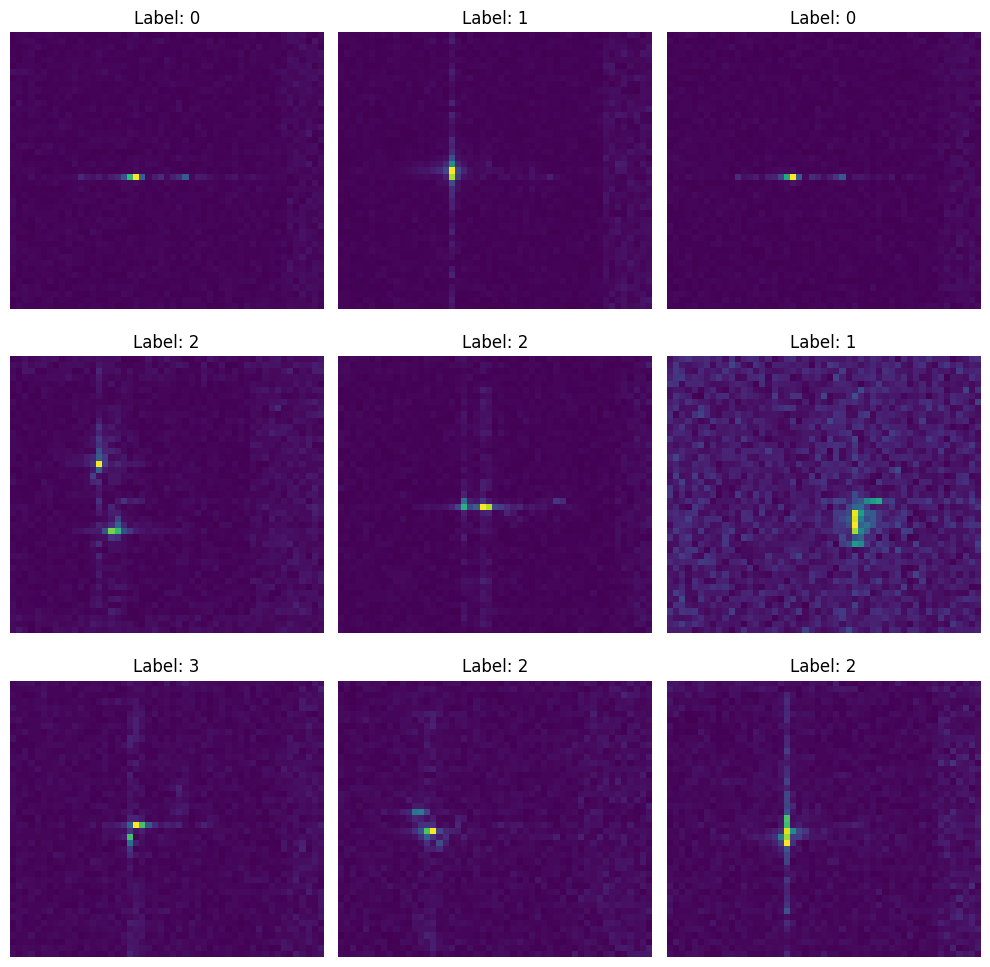

In [6]:

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(45, 51, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])


In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [9]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='max',
    restore_best_weights=True
)


In [10]:
history = model.fit(train_images, labels, epochs=10, batch_size=16, validation_split=0.2, verbose=2, callbacks=[early_stopping])


Epoch 1/10
810/810 - 11s - loss: 0.7452 - accuracy: 0.7477 - val_loss: 0.5085 - val_accuracy: 0.8119 - 11s/epoch - 13ms/step
Epoch 2/10
810/810 - 4s - loss: 0.4424 - accuracy: 0.8487 - val_loss: 0.3851 - val_accuracy: 0.8733 - 4s/epoch - 4ms/step
Epoch 3/10
810/810 - 3s - loss: 0.3714 - accuracy: 0.8741 - val_loss: 0.3566 - val_accuracy: 0.8764 - 3s/epoch - 4ms/step
Epoch 4/10
810/810 - 3s - loss: 0.3260 - accuracy: 0.8949 - val_loss: 0.3033 - val_accuracy: 0.8959 - 3s/epoch - 4ms/step
Epoch 5/10
810/810 - 4s - loss: 0.3017 - accuracy: 0.9024 - val_loss: 0.2836 - val_accuracy: 0.9052 - 4s/epoch - 5ms/step
Epoch 6/10
810/810 - 3s - loss: 0.2781 - accuracy: 0.9098 - val_loss: 0.2570 - val_accuracy: 0.9203 - 3s/epoch - 4ms/step
Epoch 7/10
810/810 - 3s - loss: 0.2590 - accuracy: 0.9194 - val_loss: 0.2577 - val_accuracy: 0.9166 - 3s/epoch - 4ms/step
Epoch 8/10
810/810 - 4s - loss: 0.2508 - accuracy: 0.9191 - val_loss: 0.2329 - val_accuracy: 0.9262 - 4s/epoch - 4ms/step
Epoch 9/10
810/810 - 

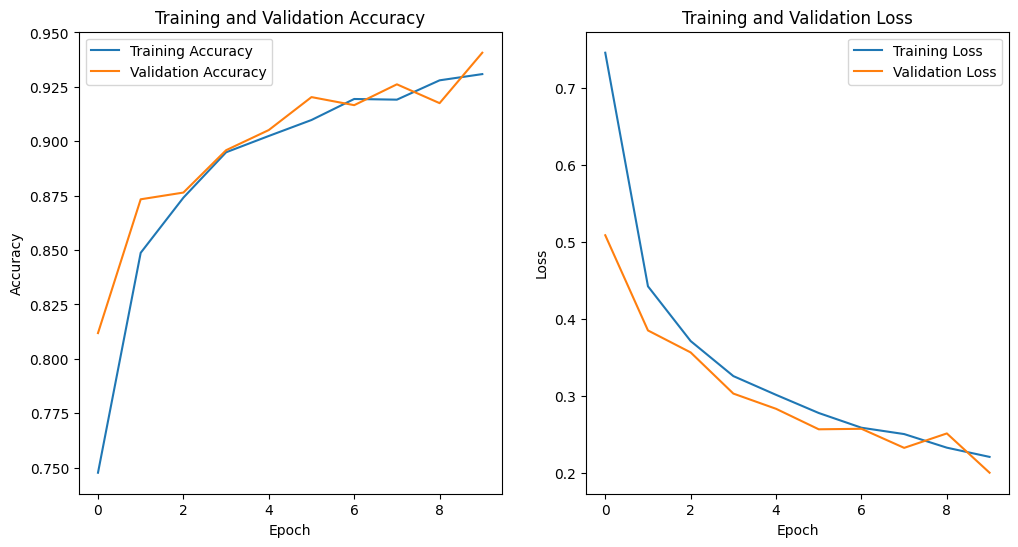

In [11]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [12]:

predictions = model.predict(test_images)
print(predictions)


150/150 [==============================] - 1s 4ms/step
[[7.00602914e-06 9.94505465e-01 5.37083112e-03 1.16724965e-04]
 [3.23888507e-08 1.41196307e-02 1.55046880e-02 9.70375717e-01]
 [1.02808970e-08 3.14304743e-05 4.90682796e-02 9.50900376e-01]
 ...
 [9.99996662e-01 3.28208100e-10 1.13953729e-06 2.23963912e-06]
 [9.99997497e-01 9.79800130e-11 8.24357983e-07 1.69806731e-06]
 [5.81782497e-03 5.83520334e-04 9.93595064e-01 3.51052336e-06]]


In [13]:
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)


[1 3 3 ... 0 0 2]


In [14]:
ids = np.arange(0, len(predicted_classes))
df = pd.DataFrame({
    'id': ids,
    'target': predicted_classes
})
csv_file_path = '/content/my_submission_diff.csv'
df.to_csv(csv_file_path, index=False)